In [69]:
import openmc
import numpy as np
import matplotlib.pyplot as plt
import os

## Week 2: Depletion in OpenMC

First we create materials, geometry, settings, as usual

In [27]:
# Materials
fuel = openmc.Material()
fuel.add_element('U', percent=0.333, enrichment=5.0)
fuel.add_element('O', percent=0.666, percent_type='ao')
fuel.set_density('g/cm3', density=10.5)
fuel.volume = np.pi * 1.5**2
# because fuel has Uranium in it, the 'depletable' attribute is set as True.
# Any material can has this attribute set manually by the user

water = openmc.Material(name='water')
water.add_element('H', percent=0.666)
water.add_element('O', percent=0.333)
water.set_density('g/cm3', density=1.0)

mats = openmc.Materials([fuel, water])


# Geometry
geo = openmc.Geometry()

s1 = openmc.ZCylinder(r=1.5)
c1 = openmc.Cell(region=-s1, name='fuel')
c1.fill = fuel

bb = openmc.model.rectangular_prism(5.0, 5.0, boundary_type='reflective')
c2 = openmc.Cell(region=(+s1 & bb), name='water')
c2.fill = water

univ = openmc.Universe(cells=[c1, c2])

geo.root_universe = univ

# Settings
settings = openmc.Settings()
settings.particles = 1000
settings.batches = 50
settings.inactive = 10
settings.seed = 5

OpenMC's depletion module is entirely in Python! Let's go over the basic classes we can use:

In [3]:
import openmc.deplete as od

In [ ]:
model = openmc.Model(geometry=geo, materials=mats, settings=settings)

# CoupledOperator
cou_op = od.CoupledOperator(model, chain_file='chain_simple.xml')

# IndependentOperator

microxs = od.MicroXS.from_model(model,
                                fuel,
                                chain_file='chain_simple.xml')

In [50]:
ind_op = od.IndependentOperator(mats, microxs, chain_file='chain_simple.xml')

In [51]:
# Integrator
integrator = od.PredictorIntegrator(ind_op, np.ones(7), power=9000, timestep_units='d')
integrator.integrate()



In [52]:
integrator = od.PredictorIntegrator(cou_op, np.ones(7), power=9000, timestep_units='d')
integrator.integrate()

[openmc.deplete] t=0.0 s, dt=86400.0 s, source=9000
[openmc.deplete] t=86400.0 s, dt=86400.0 s, source=9000
[openmc.deplete] t=172800.0 s, dt=86400.0 s, source=9000
[openmc.deplete] t=259200.0 s, dt=86400.0 s, source=9000
[openmc.deplete] t=345600.0 s, dt=86400.0 s, source=9000
[openmc.deplete] t=432000.0 s, dt=86400.0 s, source=9000
[openmc.deplete] t=518400.0 s, dt=86400.0 s, source=9000
[openmc.deplete] t=604800.0 (final operator evaluation)


In [61]:
# Analyzing results
independent_results = od.Results.from_hdf5('depletion_results.h5')
coupled_results = od.Results.from_hdf5('depletion_results.h5')

In [65]:
nuc='U235'
t, nuc_i = independent_results.get_atoms(mats[0], nuc=nuc)
t, nuc_c = coupled_results.get_atoms(mats[0], nuc=nuc)

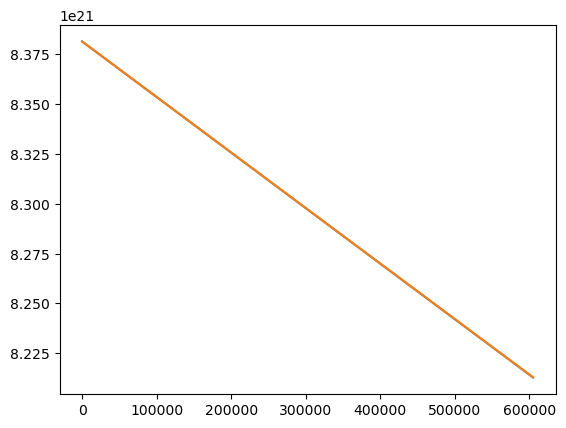

In [66]:
plt.plot(t, nuc_i)
plt.plot(t, nuc_c)

In [67]:
(xe135_i - xe135_c) / xe135_c

array([ 0.00000000e+00,  0.00000000e+00, -2.34578686e-06, -3.04079371e-06,
       -6.67509741e-06, -9.15430596e-06, -1.00530896e-05, -1.28770626e-05])

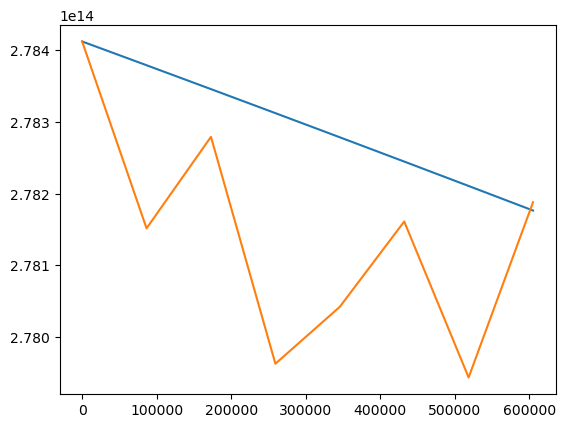

In [68]:
nuc='U235'
rx='fission'
t, rx_i = independent_results.get_reaction_rate(mats[0], nuc=nuc, rx=rx)
t, rx_c = coupled_results.get_reaction_rate(mats[0], nuc=nuc, rx=rx)
plt.plot(t, rx_i)
plt.plot(t, rx_c)